In [1]:
import numpy as np
import elli
from elli.fitting import ParamsHist
from lmfit import minimize, fit_report
import matplotlib.pyplot as plt

In [2]:
data = elli.read_nexus_psi_delta("SiO2onSi.ellips.nxs").loc[(slice(None), slice(210, 800)), :]
lbda = data.loc[50].index.get_level_values("Wavelength").to_numpy()
data

Ψ           Δ
Angle of Incidence Wavelength                       
50                 210.0       40.028156  146.370560
                   211.0       40.012478  146.607407
                   212.0       40.007420  146.799438
                   213.0       40.005928  147.055832
                   214.0       40.001190  147.294281
...                                  ...         ...
70                 796.0        9.051100  174.423874
                   797.0        9.054414  174.494553
                   798.0        9.044289  174.405136
                   799.0        9.048944  174.376541
                   800.0        9.021362  174.418228

[1773 rows x 2 columns]

In [3]:
rii_db = elli.db.RII()
Si = rii_db.get_mat("Si", "Aspnes")

params = ParamsHist()
params.add("SiO2_n0", value=1.452, min=-100, max=100, vary=True)
params.add("SiO2_n1", value=36.0, min=-40000, max=40000, vary=True)
params.add("SiO2_n2", value=0, min=-40000, max=40000, vary=False)
params.add("SiO2_k0", value=0, min=-100, max=100, vary=False)
params.add("SiO2_k1", value=0, min=-40000, max=40000, vary=False)
params.add("SiO2_k2", value=0, min=-40000, max=40000, vary=False)
params.add("SiO2_d", value=20, min=0, max=40000, vary=True)

In [4]:
def model(lbda, angle, params):
    SiO2 = elli.Cauchy(
        params["SiO2_n0"],
        params["SiO2_n1"],
        params["SiO2_n2"],
        params["SiO2_k0"],
        params["SiO2_k1"],
        params["SiO2_k2"],
    ).get_mat()

    structure = elli.Structure(
        elli.AIR,
        [elli.Layer(SiO2, params["SiO2_d"])],
        Si,
    )
    
    return structure.evaluate(lbda, angle, solver=elli.Solver2x2)

In [5]:
def fit_function(params, lbda, data):
    residual = []

    for phi_i in [50, 60, 70]:
        model_result = model(lbda, phi_i, params)
            
        resid_psi = data.loc[(phi_i, "Ψ")].to_numpy() - model_result.psi
        resid_delta = data.loc[(phi_i, "Δ")].to_numpy() - model_result.delta

        residual.append(resid_psi)
        residual.append(resid_delta)

    return np.concatenate(residual)

In [6]:
out = minimize(fit_function, params, args=(lbda, data), method="leastsq")
print(fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 119
    # data points      = 3546
    # variables        = 3
    chi-square         = 157.748841
    reduced chi-square = 0.04452409
    Akaike info crit   = -11031.1779
    Bayesian info crit = -11012.6572
[[Variables]]
    SiO2_n0:  1.63549687 +/- 0.03012997 (1.84%) (init = 1.452)
    SiO2_n1:  27.6408772 +/- 8.75248284 (31.66%) (init = 36)
    SiO2_n2:  0 (fixed)
    SiO2_k0:  0 (fixed)
    SiO2_k1:  0 (fixed)
    SiO2_k2:  0 (fixed)
    SiO2_d:   1.75831329 +/- 0.02404272 (1.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(SiO2_n0, SiO2_d)  = -0.9916
    C(SiO2_n0, SiO2_n1) = -0.9596
    C(SiO2_n1, SiO2_d)  = +0.9259


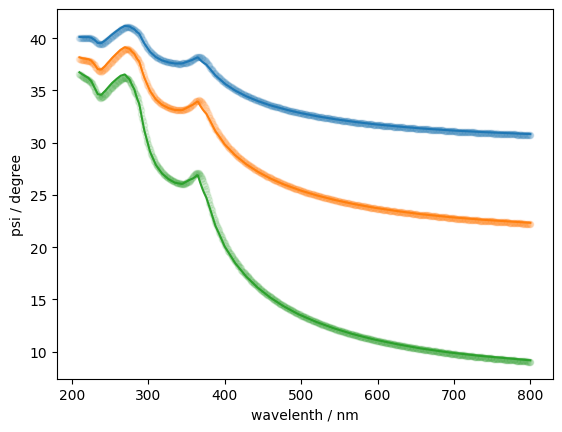

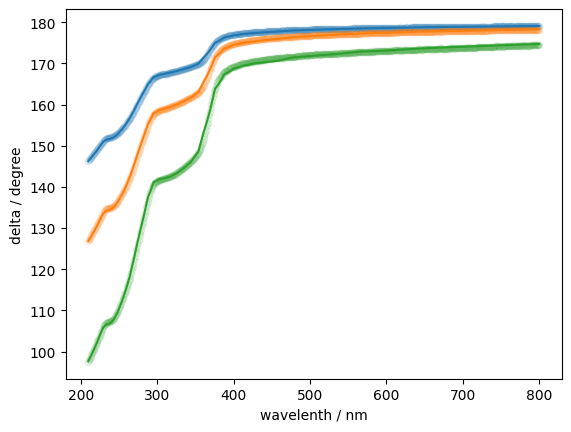

In [7]:
fit_50 = model(lbda, 50, out.params)
fit_60 = model(lbda, 60, out.params)
fit_70 = model(lbda, 70, out.params)

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(lbda, data.loc[(50, "Ψ")], s=20, alpha=0.1, label="Psi 50° Measurement")
ax.scatter(lbda, data.loc[(60, "Ψ")], s=20, alpha=0.1,  label="Psi 60° Measurement")
ax.scatter(lbda, data.loc[(70, "Ψ")], s=20, alpha=0.1,  label="Psi 70° Measurement")
ax.plot(lbda, fit_50.psi, c="tab:blue", label="Psi 50° Simulation")
ax.plot(lbda, fit_60.psi, c="tab:orange", label="Psi 60° Simulation")
ax.plot(lbda, fit_70.psi, c="tab:green", label="Psi 70° Simulation")
ax.set_xlabel('wavelenth / nm')
ax.set_ylabel('psi / degree')
fig.canvas.draw()

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(lbda, data.loc[(50, "Δ")], s=20, alpha=0.1, label="Delta 50° Measurement")
ax.scatter(lbda, data.loc[(60, "Δ")], s=20, alpha=0.1,  label="Delta 60° Measurement")
ax.scatter(lbda, data.loc[(70, "Δ")], s=20, alpha=0.1,  label="Delta 70° Measurement")
ax.plot(lbda, fit_50.delta, c="tab:blue", label="Delta 50° Simulation")
ax.plot(lbda, fit_60.delta, c="tab:orange", label="Delta 60° Simulation")
ax.plot(lbda, fit_70.delta, c="tab:green", label="Delta 70° Simulation")
ax.set_xlabel('wavelenth / nm')
ax.set_ylabel('delta / degree')
fig.canvas.draw()